# Importing the Necessary Libraries 

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import zscore
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima


# Load the Dataset

In [2]:
df = pd.read_csv("/Users/luffy_015/Desktop/WATER/final_data.csv")

/var/folders/6f/hrr6km6x5l39n_12_r7994t00000gn/T/ipykernel_64685/3026616376.py:1: DtypeWarning: Columns (17,18,20,22,23,25,26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/Users/luffy_015/Desktop/WATER/final_data.csv")


# Reshapeing the Data 

In [3]:
df_wide = df.pivot_table(
    index=["sample_date_time"],
    columns="determinand_label",
    values="result",
    aggfunc="first"
).reset_index()

# 3. Flatten the column hierarchy (pivot_table can create MultiIndex columns)
df_wide.columns.name = None  # remove the name from columns
df_wide.head()


,sample_date_time,Ammonia(N),BOD ATU,Nitrate-N,Sld Sus@105C,pH
0,2018-01-02 07:50:00,NaN,NaN,NaN,NaN,8.00
1,2018-01-02 07:53:00,0.0330,NaN,6.030,10.20,NaN
2,2018-01-02 08:07:00,0.0191,NaN,1.940,8.07,7.90
3,2018-01-02 08:21:00,0.0028,NaN,0.431,NaN,7.97
4,2018-01-02 08:26:00,0.0660,NaN,3.080,16.90,7.89


In [4]:
df_wide = df.pivot_table(
    index=['sample_date_time', 'northing', 'easting', 'local_authority_name',
       'sample_type', 'year', 'industry', 'offices', 'retail', 'storage_and_warehousing',
       'industry_and_commerce_total', 'landfill_and_waste_disposal',
       'minerals_and_mining', 'minerals_and_landfill_total',
       'institutional_and_communal_accommodations', 'residential',
       'residential_total', 'highways_and_road_transport', 'transport_other',
       'utilities', 'transport_and_utilities_total', 'agricultural_buildings',
       'agricultural_land', 'agriculture_total', 'grand_total'],
    columns="determinand_label",
    values="result",
    aggfunc="first"
).reset_index()
#drop rows that do not have all paramateres measured so df only contains sampling points where all the parameters have been measured and theres no missing data 
df = df_wide.dropna().copy()


# Handeling Missing Values 

In [5]:
#handle object dtypes that are supposed to be numeric
columns= ['industry_and_commerce_total', 'landfill_and_waste_disposal', 'minerals_and_mining', 'minerals_and_landfill_total', 'residential', 'residential_total', 'highways_and_road_transport', 'transport_other', 'utilities', 'transport_and_utilities_total', 'agricultural_buildings', 'agricultural_land', 'agriculture_total', 'grand_total'] 
for column in columns:
    df[column] = df[column].astype(str).str.strip()
    df[column] = df[column].astype(str).str.replace(r'[^0-9.]', '', regex=True)
    df[column] = pd.to_numeric(df[column])

df = df.drop(['northing', 'easting', 	
              'sample_type', 
              'offices', 
              'retail',
              'industry_and_commerce_total',
              'landfill_and_waste_disposal', 
              'minerals_and_landfill_total',
              'institutional_and_communal_accommodations',
              'residential',
              'utilities', 
              'transport_and_utilities_total', 
              'agricultural_buildings',
              'agricultural_land'], axis = 1)

print(df.isnull().sum())

determinand_label
sample_date_time                  0
local_authority_name              0
year                              0
industry                          0
storage_and_warehousing           0
minerals_and_mining            2423
residential_total                 0
highways_and_road_transport       0
transport_other                   0
agriculture_total                 0
grand_total                       0
Ammonia(N)                        0
BOD ATU                           0
Nitrate-N                         0
Sld Sus@105C                      0
pH                                0
dtype: int64


In [6]:
# Handeling the missing values 
df.fillna(0, inplace=True)

# Factor Columns 

In [7]:
# factor columns
df['industry_total'] = df['industry'] + df['storage_and_warehousing']
df['transport_total'] = df['highways_and_road_transport'] + df['transport_other']
df['industry_percentage'] = (df['industry_total'] / df['grand_total']) * 100
df['minerals_percentage'] = (df['minerals_and_mining'] / df['grand_total']) * 100 
df['residential_percentage'] = (df['residential_total'] / df['grand_total']) * 100
df['transport_percentage'] = (df['transport_total'] / df['grand_total']) * 100
df['agriculture_percentage'] = (df['agriculture_total'] / df['grand_total']) * 100

# Numeric columns
numeric_cols = ['Ammonia(N)', 'BOD ATU', 'Nitrate-N', 'Sld Sus@105C', 'pH',
       'industry_percentage', 'minerals_percentage', 'residential_percentage',
       'transport_percentage', 'agriculture_percentage']

# Selecting the parameters 
parameters = ['Ammonia(N)', 'BOD ATU', 'Nitrate-N', 'Sld Sus@105C', 'pH']

# ARIMA Model For Ammonia 
## Time Series Decomposition
> The decomposition plot breaks the time series into:
- **Observed**: The raw ammonia levels with noticeable fluctuations over time.
- **Trend**: A slowly varying component, indicating some general downward trend followed by stabilization.
- **Seasonal**: Small, consistent fluctuations repeating over a yearly cycle, suggesting minor seasonal influence.
- **Residual**: Irregular fluctuations, likely noise or unexplained variance after trend and seasonality removal.

## Model Selection via AIC
> From the ARIMA stepwise search:
- The model with the lowest AIC = -598.246 corresponds to ARIMA(5,1,0)(2,1,0)[12].
- The [12] indicates seasonality is modeled on a yearly basis (monthly data).
- Lower AIC indicates a better model, balancing complexity and fit.

## Residual Diagnostics
>The residual diagnostics include:
- Standardized residual plot: No obvious pattern, which is a good sign.
- Histogram + KDE: Residuals appear approximately normally distributed.
- Q-Q Plot: Points lie close to the diagonal, confirming normality.
- Correlogram (ACF plot): No significant autocorrelations left, indicating white noise.

These diagnostics confirm that the model is well-fitted, and residuals behave like white noise.

## Forecasting Results
- 3-Year Forecast (Red Line) vs Historical Data (Blue Line)
- The forecast shows a stable mean around 0.755 mg/L.
- Prediction interval (shaded area) widens over time, indicating increasing uncertainty.
- No strong upward or downward trend predicted.

## Forecast Summary Statistics
> Interpretation: The ammonia concentration is expected to remain fairly stable over the next 3 years, fluctuating slightly around 0.755 mg/L.

## Key Insights
- Model Fit: The seasonal ARIMA(5,1,0)(2,1,0)[12] model fits well with the data, minimizing AIC and leaving white noise residuals.
- Seasonality: Minor seasonality exists but is not the dominant feature.
- Stability: Forecasted ammonia levels are stable, with no strong trend expected in the future.
- Reliability: Residuals pass normality and autocorrelation tests, affirming model assumptions.








/var/folders/6f/hrr6km6x5l39n_12_r7994t00000gn/T/ipykernel_64685/3813443769.py:63: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df[param_col].resample("M").mean().dropna()


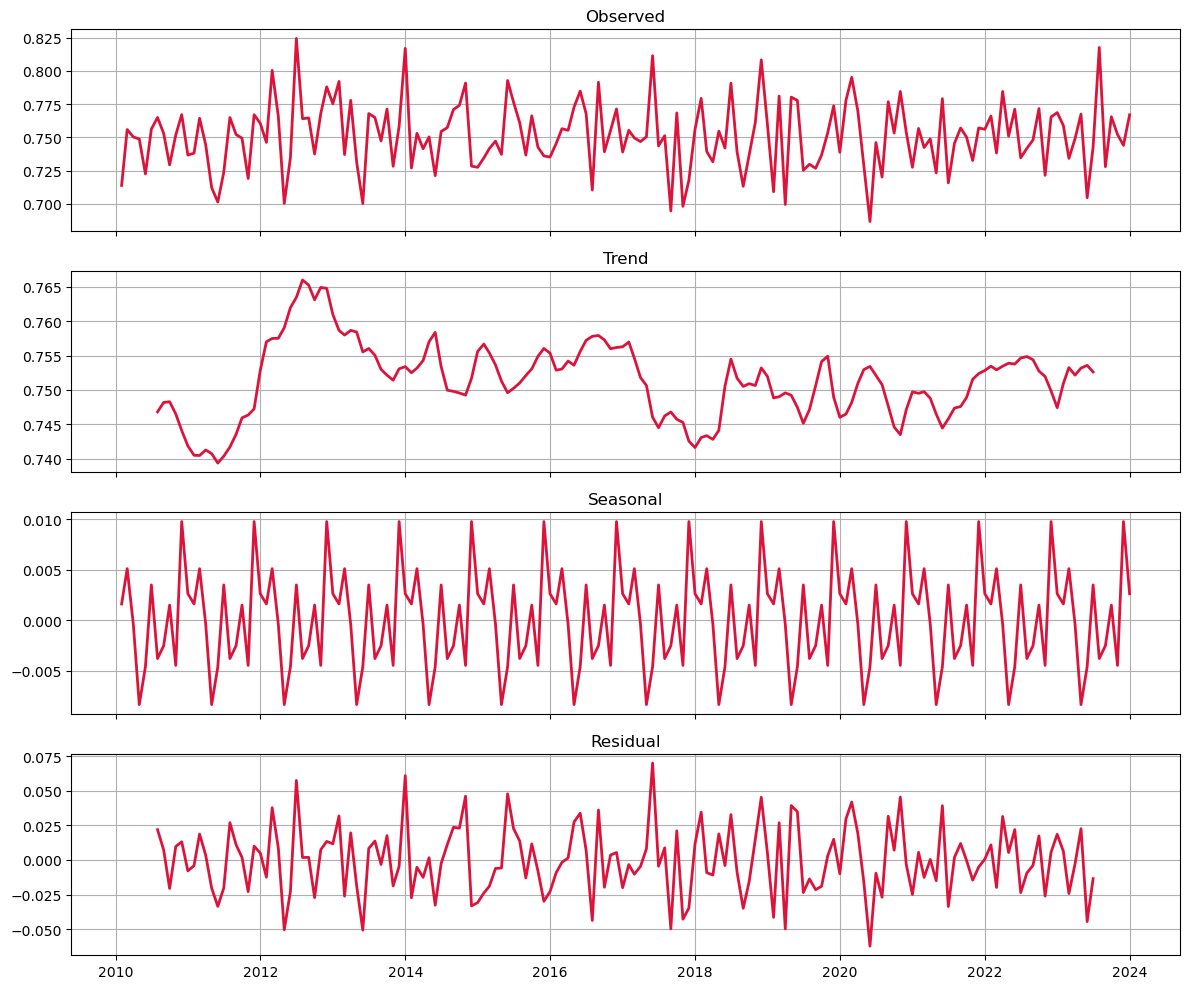

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.77 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-466.005, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-560.519, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.50 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-519.964, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-564.645, Time=0.36 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.40 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.38 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-522.107, Time=0.46 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-580.084, Time=0.75 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-577.704, Time=0.26 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.79 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.22 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=-587.641, Time=0.88 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=-586.2

/var/folders/6f/hrr6km6x5l39n_12_r7994t00000gn/T/ipykernel_64685/3813443769.py:91: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_index = pd.date_range(


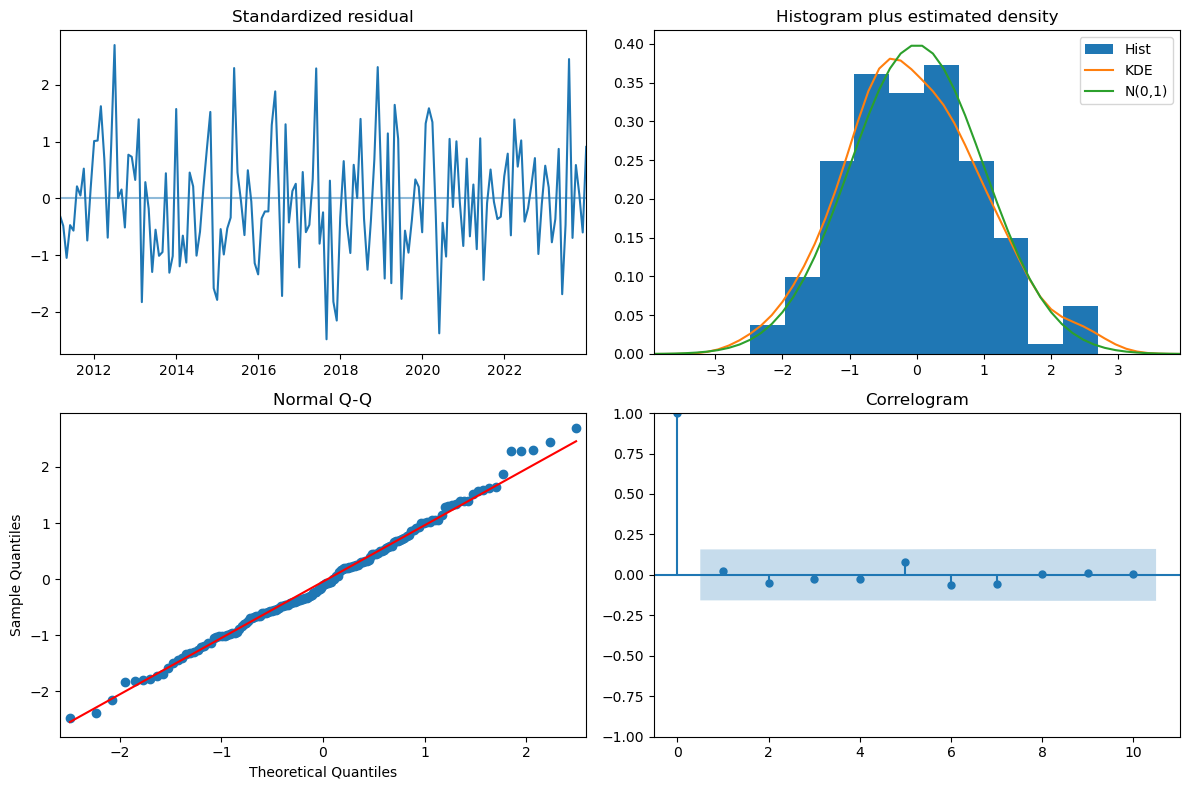

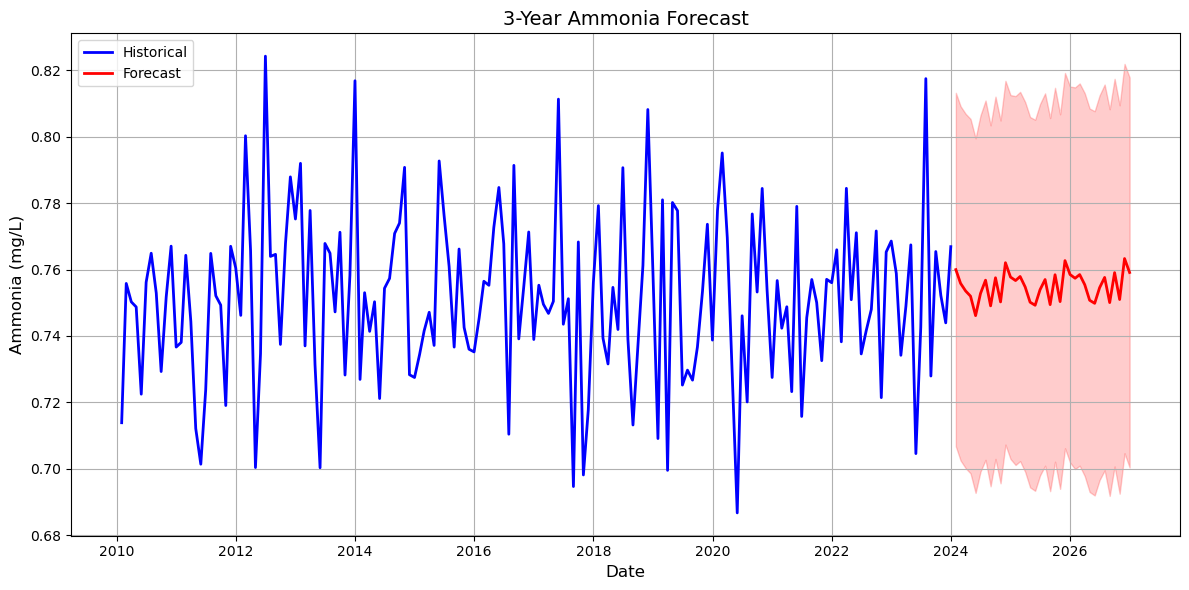

Forecast Summary:
count    36.000000
mean      0.754978
std       0.004368
min       0.746111
25%       0.750646
50%       0.755641
75%       0.758038
max       0.763313
dtype: float64


In [8]:
# For Ammonoia
def plot_seasonal_decompose(series):
    result = seasonal_decompose(series, model='additive')
    fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
    
    axes[0].plot(result.observed, color='crimson', linewidth=2)
    axes[0].set_title('Observed')
    axes[0].grid(True)
    
    axes[1].plot(result.trend, color='crimson', linewidth=2)
    axes[1].set_title('Trend')
    axes[1].grid(True)
    
    axes[2].plot(result.seasonal, color='crimson', linewidth=2)
    axes[2].set_title('Seasonal')
    axes[2].grid(True)
    
    axes[3].plot(result.resid, color='crimson', linewidth=2)
    axes[3].set_title('Residual')
    axes[3].grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_diagnostics(results):
    fig = results.plot_diagnostics(figsize=(12, 8))
    plt.tight_layout()
    plt.show()

def forecast_ammonia_3yr(
    df,
    date_col="sample_date_time",
    param_col="Ammonia(N)",
    ammonia_min=0.5,
    ammonia_max=1.0
):
    # Drop missing values
    df = df.dropna(subset=[param_col]).copy()
    
    # Calculate IQR bounds using 0.1 and 0.9 quantiles
    q10 = df[param_col].quantile(0.1)
    q90 = df[param_col].quantile(0.9)
    iqr = q90 - q10
    
    # Define outlier bounds with IQR method
    lower_bound = q10 - 1.5 * iqr
    upper_bound = q90 + 1.5 * iqr
    
    # Apply IQR filtering
    df = df[(df[param_col] >= lower_bound) & 
            (df[param_col] <= upper_bound)].copy()
    
    # Apply domain constraints
    df = df[(df[param_col] >= ammonia_min) & 
            (df[param_col] <= ammonia_max)].copy()
    
    # Convert and sort datetime
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df.sort_values(date_col, inplace=True)
    df.set_index(date_col, inplace=True)
    
    # Resample to monthly means
    df_monthly = df[param_col].resample("M").mean().dropna()
    
    if len(df_monthly) < 12:
        raise ValueError("Insufficient data after filtering (need ≥12 months)")
    
    plot_seasonal_decompose(df_monthly)
    
    try:
        auto_model = auto_arima(
            df_monthly,
            seasonal=True,
            m=12,
            start_p=0, start_q=0,
            max_p=5, max_q=5,
            d=1, D=1,
            trace=True,
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True
        )
        
        forecast_steps = 36
        forecast_vals, conf_int = auto_model.predict(
            n_periods=forecast_steps,
            return_conf_int=True
        )
        
        last_date = df_monthly.index[-1]
        future_index = pd.date_range(
            start=last_date + pd.DateOffset(months=1),
            periods=forecast_steps,
            freq='M'
        )
        
        forecast_vals = pd.Series(forecast_vals, index=future_index)
        conf_int = pd.DataFrame(
            conf_int,
            index=future_index,
            columns=['lower', 'upper']
        )
        
        print(auto_model.summary())
        plot_diagnostics(auto_model)
        
    except Exception as e:
        print(f"Modeling error: {e}")
        return None, None

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(df_monthly, label="Historical", color="blue", linewidth=2)
    plt.plot(forecast_vals, label="Forecast", color="red", linewidth=2)
    plt.fill_between(future_index, conf_int['lower'], conf_int['upper'],
                     color="red", alpha=0.2)
    plt.title("3-Year Ammonia Forecast", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Ammonia (mg/L)", fontsize=12)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return forecast_vals, conf_int

# execution
if __name__ == "__main__":
    date_rng = pd.date_range("2010-01-01", "2023-12-01", freq="D")
    np.random.seed(42)
    synthetic_data = 0.75 + np.random.normal(loc=0, scale=0.2, size=len(date_rng))
    
    df_demo = pd.DataFrame({
        "sample_date_time": date_rng,
        "Ammonia(N)": np.clip(synthetic_data, 0.4, 1.1)
    })
    
    forecast, ci = forecast_ammonia_3yr(
        df_demo,
        ammonia_min=0.5,
        ammonia_max=1.0
    )
    
    print("Forecast Summary:")
    print(forecast.describe())


# ARIMA Model For pH 
## Time Series Decomposition
> The decomposition plot breaks the pH time series into:
- Observed: The raw pH values range between approximately 7.4 and 7.6, showing mild fluctuation.
- Trend: A subtle downward trend from 2010 to around 2020, followed by stabilization.
- Seasonal: A consistent annual cyclic pattern is visible, indicating a clear seasonal component.
- Residual: Displays random noise with no obvious pattern — remaining variance after accounting for trend and seasonality.

## Model Summary: SARIMA
> The model selected is:
- SARIMAX(1,1,1)(1,1,1,12)
    - This means:
    - (1,1,1) – ARIMA component for non-seasonal trends.
    - (1,1,1,12) – Seasonal component with yearly seasonality (monthly data).

- Key Metrics:
    - AIC: -364.464
    - BIC: -349.721
    - Log Likelihood: 187.232

- Coefficient Significance:
None of the parameters (AR, MA, SAR, SMA) are statistically significant individually (high p-values), but that does not invalidate the model if residuals are well-behaved.

## Residual Diagnostics
> The residual diagnostics include:
- Standardized residual plot: Fluctuates randomly around zero — no autocorrelation or pattern detected.
- Histogram + KDE: Residuals approximate a normal distribution.
- Q-Q Plot: Points align closely with the diagonal — confirming normality of residuals.
- Correlogram (ACF): All autocorrelations fall within the confidence bounds — residuals resemble white noise.

Residual analysis confirms the SARIMA model is appropriate and assumptions are met.

## 3-Year Forecast for pH
- The red shaded area on the forecast plot indicates the 95% confidence interval.
- pH levels are predicted to remain fairly stable around 7.48, with very limited variation.
- No strong upward or downward trend is forecasted.

## Key Insights
- Seasonality: Clear annual seasonality exists in the pH data, modeled effectively using SARIMA.
- Stability: The pH levels are forecasted to stay stable and within a safe environmental range.
- Model Fit: SARIMAX(1,1,1)(1,1,1,12) minimizes AIC and yields white-noise residuals.
- Confidence: Residual diagnostics (normality and lack of autocorrelation) indicate a robust model.
- Forecast Usefulness: The model provides reliable future estimates with quantified uncertainty — helpful for long-term water quality monitoring.


/var/folders/6f/hrr6km6x5l39n_12_r7994t00000gn/T/ipykernel_64685/3476967883.py:59: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df[param_col].resample("M").mean().dropna()


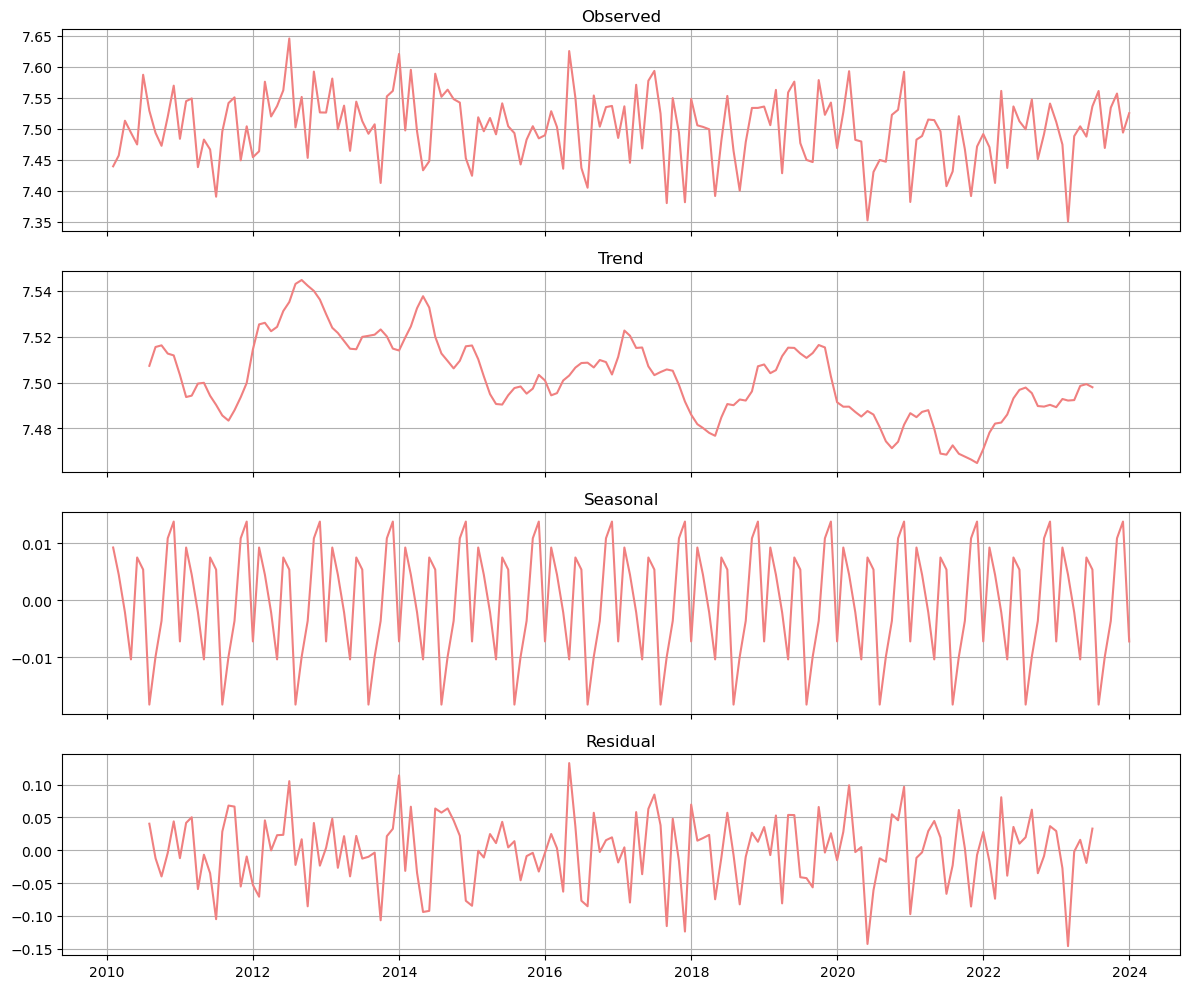

                                     SARIMAX Results                                      
Dep. Variable:                                 pH   No. Observations:                  168
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 187.232
Date:                            Thu, 27 Mar 2025   AIC                           -364.464
Time:                                    17:54:43   BIC                           -349.721
Sample:                                01-31-2010   HQIC                          -358.473
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0409      0.101      0.404      0.686      -0.157       0.239
ma.L1         -1.0001     26.333   

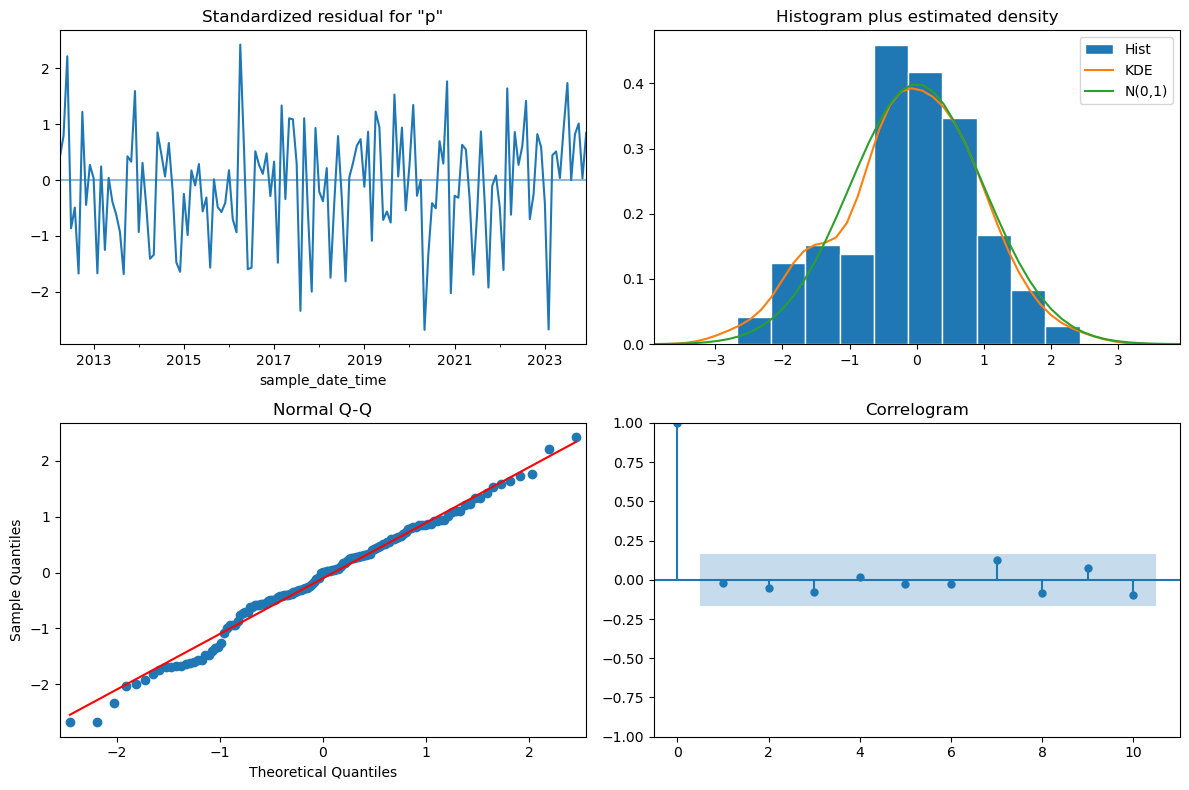

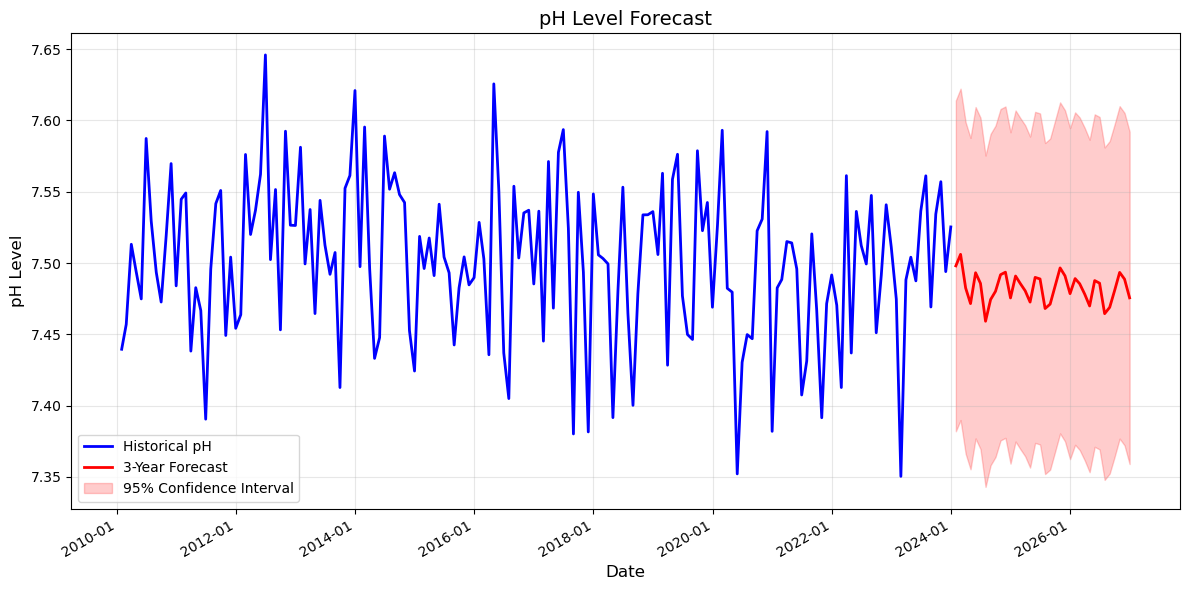


Forecast Summary:
        Forecast   Lower CI   Upper CI
count  36.000000  36.000000  36.000000
mean    7.482727   7.366437   7.599017
std     0.010423   0.010461   0.010389
min     7.459199   7.342993   7.575405
25%     7.475256   7.358811   7.591467
50%     7.484595   7.368256   7.600846
75%     7.490196   7.374102   7.606289
max     7.506110   7.389908   7.622312


In [9]:
# For pH
def plot_seasonal_decompose(series):
    result = seasonal_decompose(series, model='additive')
    fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
    
    axes[0].plot(result.observed, color='lightcoral', linewidth=1.5)
    axes[0].set_title('Observed', fontsize=12)
    axes[0].grid(True)
    
    axes[1].plot(result.trend, color='lightcoral', linewidth=1.5)
    axes[1].set_title('Trend', fontsize=12)
    axes[1].grid(True)
    
    axes[2].plot(result.seasonal, color='lightcoral', linewidth=1.5)
    axes[2].set_title('Seasonal', fontsize=12)
    axes[2].grid(True)
    
    axes[3].plot(result.resid, color='lightcoral', linewidth=1.5)
    axes[3].set_title('Residual', fontsize=12)
    axes[3].grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_diagnostics(results):
    fig = results.plot_diagnostics(figsize=(12, 8))
    plt.tight_layout()
    plt.show()

def forecast_ph_3yr(
    df: pd.DataFrame,
    date_col: str = "sample_date_time",
    param_col: str = "pH",
    ph_min: float = 5.5,
    ph_max: float = 9.5
) -> tuple[pd.Series, pd.DataFrame]:
    
    # Data preprocessing
    df = df.dropna(subset=[param_col]).copy()
    
    # Remove outliers using IQR method with 0.1 and 0.9 quantiles
    Q1 = df[param_col].quantile(0.1)
    Q3 = df[param_col].quantile(0.9)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[param_col] >= lower_bound) & (df[param_col] <= upper_bound)].copy()
    
    # Remove invalid pH values
    df = df[(df[param_col] >= ph_min) & (df[param_col] <= ph_max)].copy()

    # DateTime handling
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df = df.dropna(subset=[date_col]).copy()
    df.sort_values(by=date_col, inplace=True)
    df.set_index(date_col, inplace=True)
    
    # Resample to monthly means
    df_monthly = df[param_col].resample("M").mean().dropna()
    
    if len(df_monthly) < 12:
        raise ValueError("Minimum 12 months of data required after processing.")
    
    # Seasonal decomposition analysis
    plot_seasonal_decompose(df_monthly)
    
    try:
        # Fit SARIMA model
        model = sm.tsa.statespace.SARIMAX(
            df_monthly,
            order=(1, 1, 1),
            seasonal_order=(1, 1, 1, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        results = model.fit(disp=False)
        print(results.summary())
        plot_diagnostics(results)
        
    except Exception as e:
        print(f"Model fitting failed: {e}")
        return None, None
    
    # Generate forecast
    forecast_steps = 36
    forecast_obj = results.get_forecast(steps=forecast_steps)
    forecast_vals = forecast_obj.predicted_mean
    conf_int = forecast_obj.conf_int()
    
    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(df_monthly.index, df_monthly, 
             label="Historical pH", color="blue", linewidth=2)
    plt.plot(forecast_vals.index, forecast_vals, 
             label="3-Year Forecast", color="red", linewidth=2)
    plt.fill_between(conf_int.index,
                    conf_int.iloc[:, 0],
                    conf_int.iloc[:, 1],
                    color="red", alpha=0.2,
                    label="95% Confidence Interval")
    
    plt.title(f"pH Level Forecast", 
              fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("pH Level", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()
    
    return forecast_vals, conf_int


# Usage
if __name__ == "__main__":
    # Generate synthetic data
    date_rng = pd.date_range("2010-01-01", "2023-12-01", freq="D")
    np.random.seed(42)
    synthetic_pH = 7.5 + np.random.normal(loc=0, scale=0.3, size=len(date_rng))
    
    df_demo = pd.DataFrame({
        "sample_date_time": date_rng,
        "pH": np.clip(synthetic_pH, 5.5, 9.5)  # Hard-clip to valid range
    })
    
    # Run forecasting
    forecast, conf_int = forecast_ph_3yr(
        df_demo,
        ph_min=5.5,
        ph_max=9.5
    )
    
    if forecast is not None:
        print("\nForecast Summary:")
        print(pd.DataFrame({
            'Forecast': forecast,
            'Lower CI': conf_int.iloc[:, 0],
            'Upper CI': conf_int.iloc[:, 1]
        }).describe())

# ARIMA Model for Solids 
## Time Series Decomposition
> The decomposition of the solids time series (Sld Sus@105C) reveals:
- Observed: Solids concentrations vary between ~36 and 44 mg/L over time.
- Trend: A mild downward trend is visible over the decade, with a slight recovery towards the end.
- Seasonal: A consistent yearly pattern suggests strong seasonality.
- Residual: Unexplained variation remains in the residuals, but shows no obvious pattern — appears random.

## Model Selection via AIC
> From the stepwise AIC search:
- Best model (lowest AIC = 715.402) is ARIMA(5,1,0)(5,1,0)[12]
- The [12] seasonal order confirms monthly data with yearly seasonality.

This model balances complexity and goodness-of-fit most effectively.

## Residual Diagnostics
> The residuals of the selected model are analyzed for randomness and normality:
- Standardized residuals: Fluctuate around zero without patterns — consistent with white noise.
- Histogram + KDE: Residuals are approximately normally distributed.
- Q-Q Plot: Most points follow the reference line, indicating normal distribution.
- Correlogram (ACF): No significant autocorrelations remain — residuals are independent.

These plots confirm that the model is statistically sound and well-fitted.

## 3-Year Forecast for Solids
- The forecast chart shows the predicted solids concentration for the next 36 months with a 95% confidence interval.
- The confidence interval widens, indicating growing uncertainty over time.

## Seasonal and Trend Analysis
> Seasonality:
- Monthly means range from ~39.7 to 41.1 mg/L.
- Notably lower solids in June, July, and higher in January, February.

> Trend Analysis:
- Overall trend: Slightly decreasing.
- Average monthly change: −0.0050 mg/L.
- This suggests that while there is seasonal fluctuation, the general long-term pattern shows a gradual decline in solids concentration.

## Key Insights
- Model Fit: ARIMA(5,1,0)(5,1,0)[12] fits well, minimizing AIC with residuals behaving as white noise.
- Seasonality: Strong and consistent annual cycle, especially between summer and winter months.
- Stability & Change: While monthly variation is evident, the long-term trend shows a slight decrease.
- Forecast Use: The 3-year forecast offers a reliable projection with bounded uncertainty, making it useful for planning and monitoring.
- Environmental Relevance: Continued monitoring is recommended due to the slow downward trend, which could indicate changes in sediment or pollution dynamics.



/var/folders/6f/hrr6km6x5l39n_12_r7994t00000gn/T/ipykernel_64685/2210121960.py:59: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df[param_col].resample("M").mean().dropna()


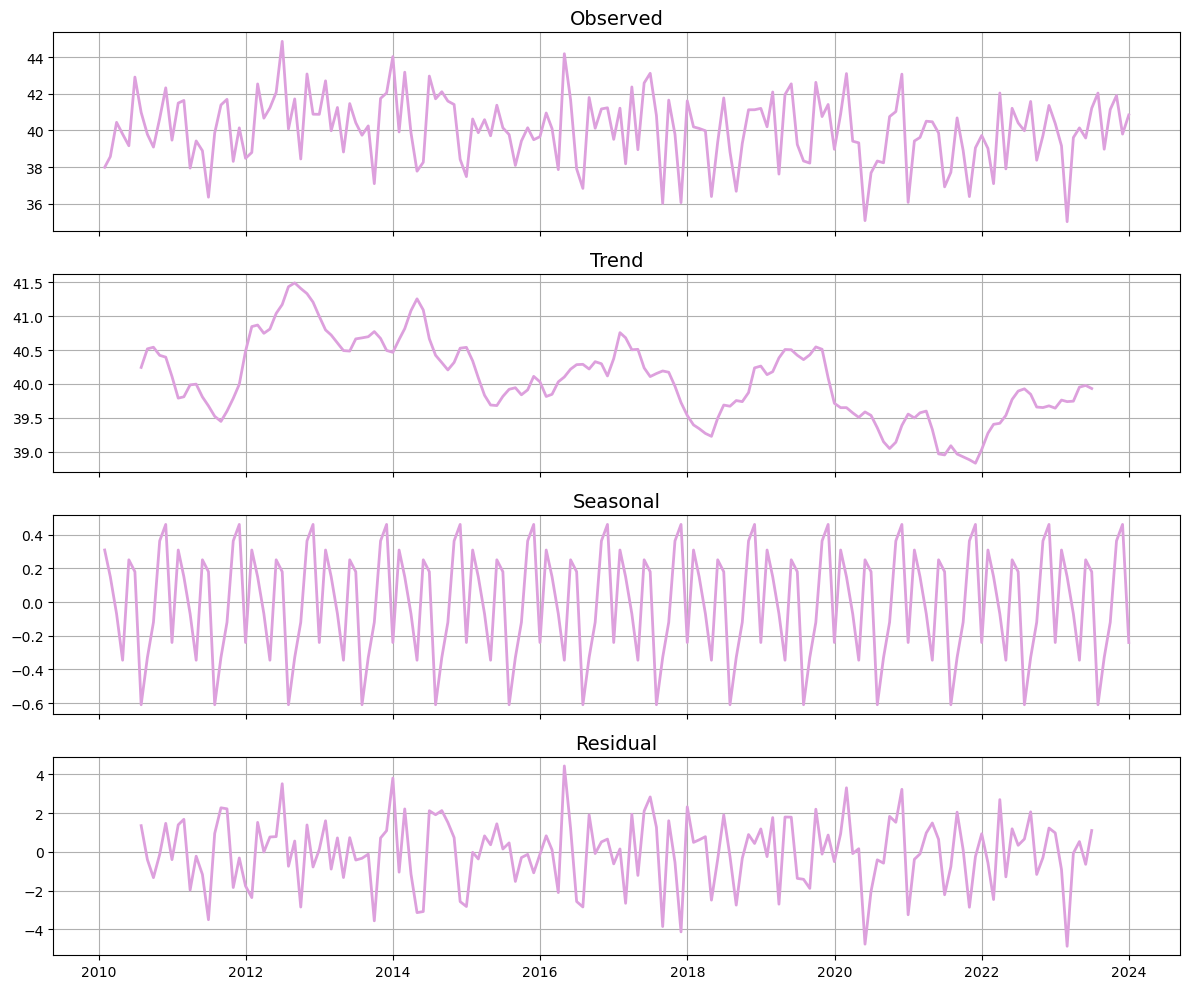

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=848.185, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=779.004, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.30 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=815.364, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=765.491, Time=0.12 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=756.418, Time=0.33 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=743.425, Time=0.76 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=743.303, Time=1.12 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=nan sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=4.65 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=774.047, Time=1.05 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=727.011, Time=1.72 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=728.261, Time=0.88 sec
 ARIMA(2,1,0)(5,1,1)[12]             : AIC=728.551, Time=6.03 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=inf

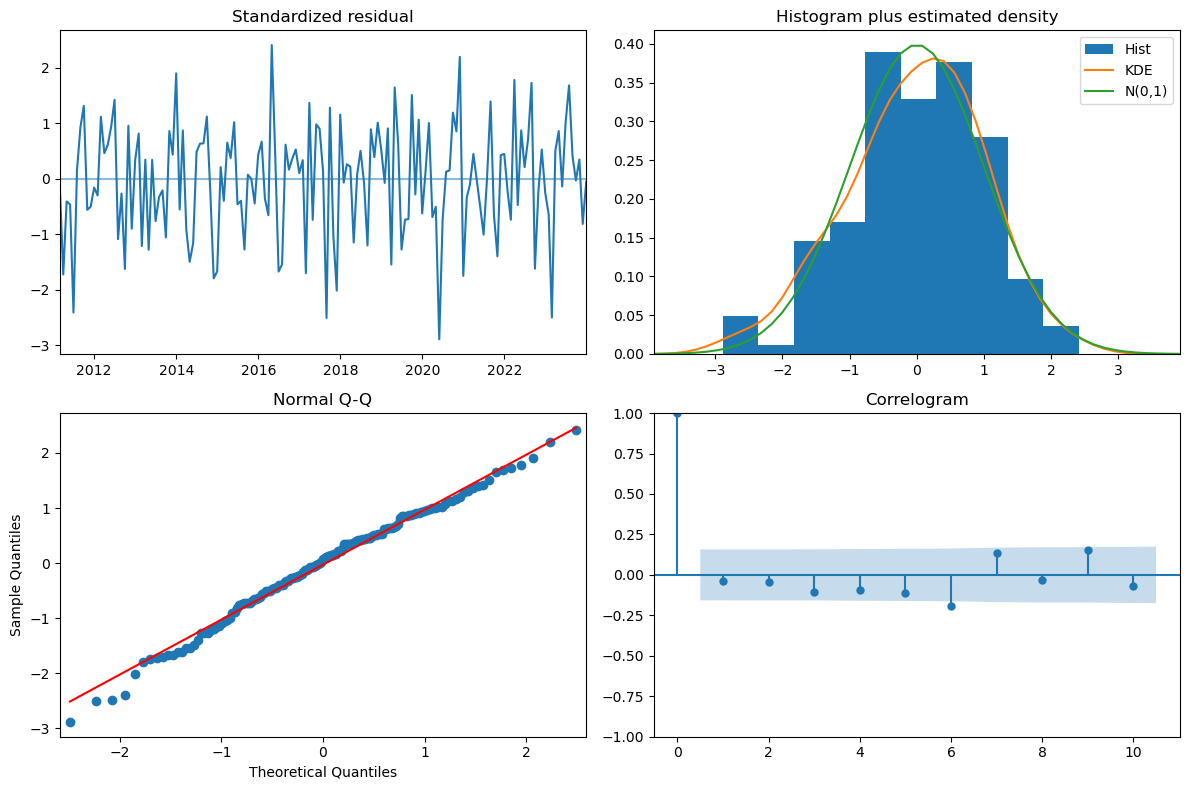

/var/folders/6f/hrr6km6x5l39n_12_r7994t00000gn/T/ipykernel_64685/2210121960.py:93: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_index = pd.date_range(


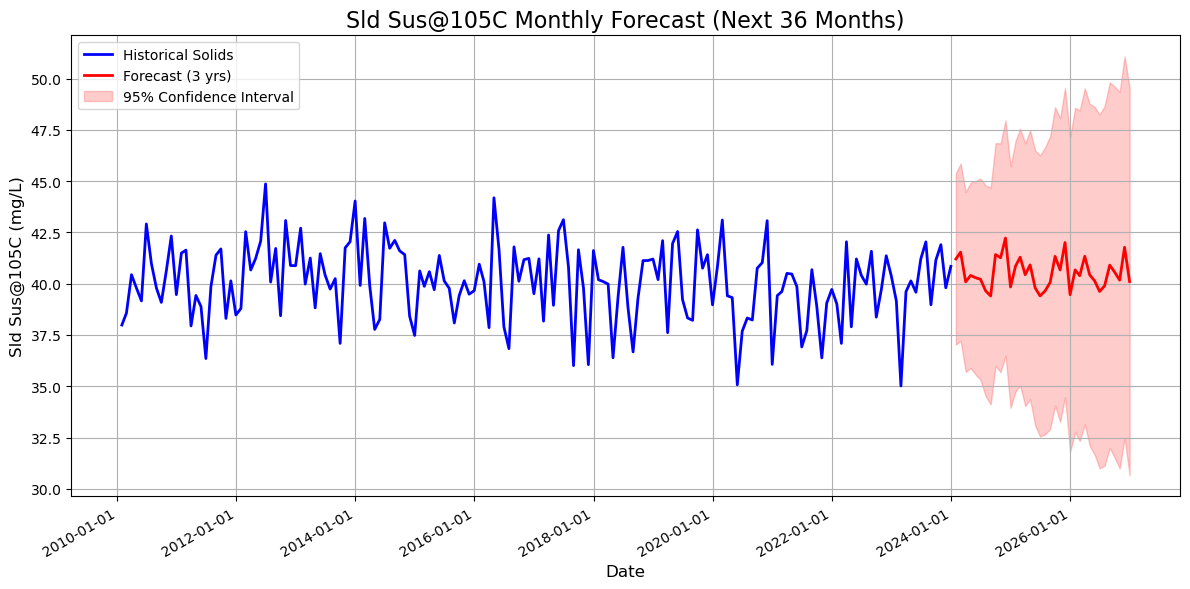


Forecast Summary:
        Forecast   Lower CI   Upper CI
count  36.000000  36.000000  36.000000
mean   40.540857  33.671919  47.409795
std     0.761255   1.828365   1.733561
min    39.400977  30.659051  44.476547
25%    40.024308  32.274686  46.158510
50%    40.419921  33.606285  47.338137
75%    41.221996  35.100112  48.631355
max    42.225565  37.217246  51.089100

Seasonal Analysis:
            mean        min        max
Month                                 
1      40.915860  40.674485  41.207474
2      41.072830  40.387525  41.538394
3      40.620598  40.089159  41.336446
4      40.585698  40.404043  40.917253
5      40.073243  39.795108  40.290201
6      39.746906  39.405407  40.214244
7      39.735035  39.650318  39.898463
8      40.124066  39.400977  40.904965
9      41.107682  40.568988  41.421807
10     40.702336  40.172359  41.265560
11     42.003451  41.775744  42.225565
12     39.802577  39.464497  40.103402

Trend Analysis:
Overall trend: Decreasing
Average monthly chang

In [10]:
# For Solids
def plot_seasonal_decompose(series):
    result = seasonal_decompose(series, model='additive')
    
    fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
    axes[0].plot(result.observed, color='plum', linewidth=2)
    axes[0].set_title('Observed', fontsize=14)
    axes[0].grid(True)

    axes[1].plot(result.trend, color='plum', linewidth=2)
    axes[1].set_title('Trend', fontsize=14)
    axes[1].grid(True)

    axes[2].plot(result.seasonal, color='plum', linewidth=2)
    axes[2].set_title('Seasonal', fontsize=14)
    axes[2].grid(True)

    axes[3].plot(result.resid, color='plum', linewidth=2)
    axes[3].set_title('Residual', fontsize=14)
    axes[3].grid(True)

    plt.tight_layout()
    plt.show()

def plot_diagnostics(results):
    fig = results.plot_diagnostics(figsize=(12, 8))
    plt.tight_layout()
    plt.show()

def forecast_sld_sus_3yr(
    df,
    date_col="sample_date_time",
    param_col="Sld Sus@105C",
    solids_min=0.0,
    solids_max=200.0
):
    # Drop missing values
    df = df.dropna(subset=[param_col]).copy()
    
    # IQR method for outlier removal
    Q1 = df[param_col].quantile(0.1)
    Q3 = df[param_col].quantile(0.9)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter out outliers
    df = df[(df[param_col] >= lower_bound) & (df[param_col] <= upper_bound)].copy()
    
    # Remove invalid solids values outside the specified range
    df = df[(df[param_col] >= solids_min) & (df[param_col] <= solids_max)].copy()

    # Convert the date column to datetime, sort by date, set index
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df.sort_values(by=date_col, inplace=True)
    df.set_index(date_col, inplace=True)
    
    # Resample monthly (mean) and drop any empty months
    df_monthly = df[param_col].resample("M").mean().dropna()
    
    if len(df_monthly) < 12:  # Need at least 12 months to model seasonality
        raise ValueError("Not enough data after filtering and resampling.")
    
    # Plot seasonal decomposition
    plot_seasonal_decompose(df_monthly)
    
    # Fit auto ARIMA model
    try:
        auto_model = auto_arima(
            df_monthly, 
            seasonal=True, 
            m=12,
            start_p=0, start_q=0, max_p=5, max_q=5,
            start_P=0, start_Q=0, max_P=5, max_Q=5,
            d=1, D=1, trace=True, error_action='ignore',
            suppress_warnings=True, stepwise=True
        )
        
        results = auto_model.fit(df_monthly)
        print(results.summary())
        
        # Plot model diagnostics
        plot_diagnostics(results)
    except Exception as e:
        print(f"Error fitting the model: {e}")
        return None, None
    
    # Forecast for 3 years (36 months)
    forecast_steps = 36
    forecast_vals, conf_int = results.predict(n_periods=forecast_steps, return_conf_int=True)
    
    # Create future index for plotting
    future_index = pd.date_range(
        start=df_monthly.index[-1] + pd.Timedelta(days=1), 
        periods=forecast_steps, 
        freq='M'
    )
    
    # Plot Historical + Future Forecast
    plt.figure(figsize=(12, 6))
    
    plt.plot(df_monthly.index, df_monthly, label="Historical Solids", color="blue", linewidth=2)
    plt.plot(future_index, forecast_vals, label="Forecast (3 yrs)", color="red", linewidth=2)
    
    plt.fill_between(
        future_index,
        conf_int[:, 0],
        conf_int[:, 1],
        color="red",
        alpha=0.2,
        label="95% Confidence Interval"
    )
    
    plt.title(f"{param_col} Monthly Forecast (Next 36 Months)", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel(f"{param_col} (mg/L)", fontsize=12)
    plt.legend()
    plt.grid(True)
    
    plt.gcf().autofmt_xdate()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    plt.tight_layout()
    plt.show()
    
    # forecast:
    if forecast_vals is not None:
        # Create a DataFrame with forecast values and confidence intervals
        forecast_df = pd.DataFrame({
            'Forecast': forecast_vals,
            'Lower CI': conf_int[:, 0],
            'Upper CI': conf_int[:, 1]
        }, index=future_index)

        print("\nForecast Summary:")
        print(forecast_df.describe())

        print("\nSeasonal Analysis:")
        forecast_df['Month'] = forecast_df.index.month
        seasonal_summary = forecast_df.groupby('Month')['Forecast'].agg(['mean', 'min', 'max'])
        print(seasonal_summary)

        print("\nTrend Analysis:")
        trend = np.polyfit(range(len(forecast_vals)), forecast_vals, 1)
        print(f"Overall trend: {'Increasing' if trend[0] > 0 else 'Decreasing'}")
        print(f"Average monthly change: {trend[0]:.4f} mg/L")

    return forecast_vals, conf_int


# Usage 
if __name__ == "__main__":
    date_rng = pd.date_range("2010-01-01", "2023-12-01", freq="D")
    
    np.random.seed(42)
    synthetic_solids = 40 + np.random.normal(loc=0, scale=10, size=len(date_rng))
    
    df_demo = pd.DataFrame({
        "sample_date_time": date_rng,
        "Sld Sus@105C": synthetic_solids
    })
    
    forecast_vals, conf_int = forecast_sld_sus_3yr(
        df_demo,
        date_col="sample_date_time",
        param_col="Sld Sus@105C",
        solids_min=0.0,
        solids_max=200.0
    )

# ARIMA Model for Nitrate 
## Time Series Decomposition
> The decomposition of the Nitrate-N series shows:
- Observed: Nitrate values fluctuate between ~7.2 and 7.8 mg/L.
- Trend: An overall slightly declining trend is visible across the observed period.
- Seasonal: A repeating yearly pattern is visible, confirming strong seasonal effects.
- Residual: Mostly random noise with no dominant structure left after removing trend and seasonality.

## Model Summary: SARIMA
> The chosen model is:
- SARIMAX(1,1,1)(1,1,1,12)
- Captures both non-seasonal and seasonal behaviors.
- Seasonal frequency [12] confirms monthly data with yearly seasonality.

- Model Metrics:
AIC: -92.664
BIC: -77.920
Log Likelihood: 51.332

| Parameter  | Coef   | P-value | Significance     |
|------------|--------|---------|-----------------|
| ar.L1      | 0.0528 | 0.612   | Not significant |
| ma.L1      | -1.0000 | 0.998   | Not significant |
| ar.S.L12   | -0.1117 | 0.224   | Not significant |
| ma.S.L12   | -1.0001 | 0.997   | Not significant |

Though individual parameters are not statistically significant, this is acceptable as long as residual diagnostics are satisfactory.

## Residual Diagnostics
> The residual diagnostic plots indicate:
- Standardized Residuals: No autocorrelation or visible patterns, centered around zero.
- Histogram + KDE: Residuals are approximately normally distributed.
- Q-Q Plot: Residuals lie close to the diagonal, confirming normality.
- Correlogram (ACF): No significant lags, confirming residuals behave like white noise.

These diagnostic results indicate that the model assumptions are well satisfied.

## 3-Year Forecast for Nitrate-N
> Forecast results show predicted values and 95% confidence intervals for the next 36 months.
- Forecast Summary: Forecast values are very close to historical averages (~7.45 mg/L).

The confidence band (in red) shows modest uncertainty, suitable for short-to-medium term planning.

## Seasonal and Trend Analysis
> Seasonality (Monthly Breakdown):

| Month | Mean (mg/L) |
|-------|------------|
| Jan   | 7.4840     |
| Feb   | 7.4857     |
| Mar   | 7.4436     |
| Apr   | 7.4265     |
| May   | 7.4706     |
| Jun   | 7.4614     |
| Jul   | 7.4060     |
| Aug   | 7.4269     |
| Sep   | 7.4543     |
| Oct   | 7.4868     |
| Nov   | 7.4729     |
| Dec   | 7.4392     |

- Higher nitrate levels appear in Jan–Feb and Oct–Nov, and relatively lower values in summer months (June–Aug).
> Trend Summary:
Overall trend: Slightly Decreasing

Average monthly change: −0.0005 mg/L

## Key Insights
- Model Fit: SARIMAX(1,1,1)(1,1,1,12) fits the data well based on AIC and residual analysis.
- Seasonality: Strong and repeatable seasonal cycle — essential to capture in any forecast model.
- Stability: Nitrate-N levels are expected to remain fairly stable, with slight fluctuations and low uncertainty.
- Forecast Usefulness: Model gives reliable 3-year projections with bounded confidence — suitable for environmental management or water quality - assessments.
- Monitoring Need: Even with stable forecast, the mild downward trend suggests the need for continued monitoring.

/var/folders/6f/hrr6km6x5l39n_12_r7994t00000gn/T/ipykernel_64685/4043679842.py:52: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df[param_col].resample("M").mean().dropna()


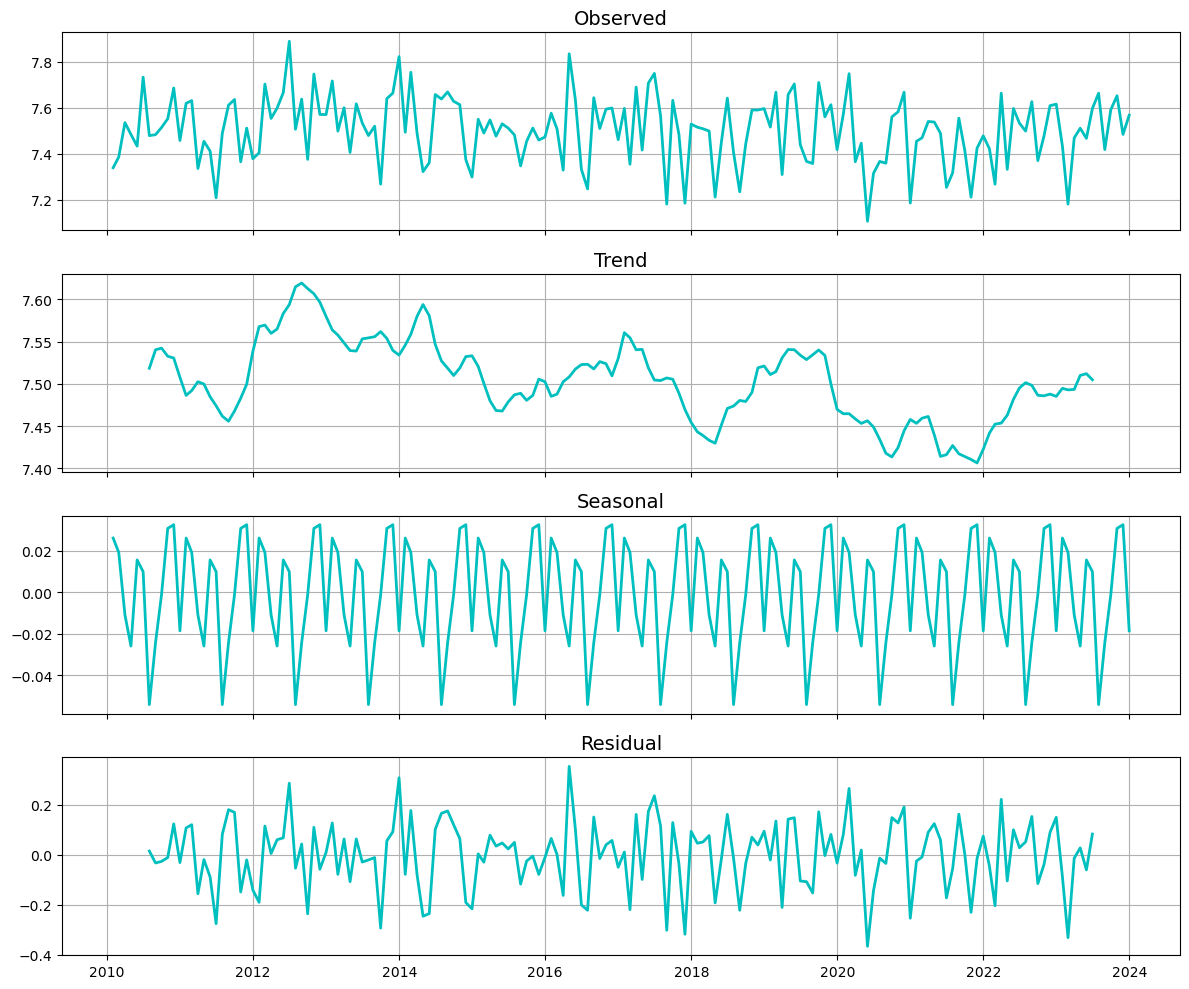

                                     SARIMAX Results                                      
Dep. Variable:                          Nitrate-N   No. Observations:                  168
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                  51.332
Date:                            Thu, 27 Mar 2025   AIC                            -92.664
Time:                                    17:57:56   BIC                            -77.920
Sample:                                01-31-2010   HQIC                           -86.672
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0528      0.104      0.508      0.612      -0.151       0.257
ma.L1         -1.0000    444.996   

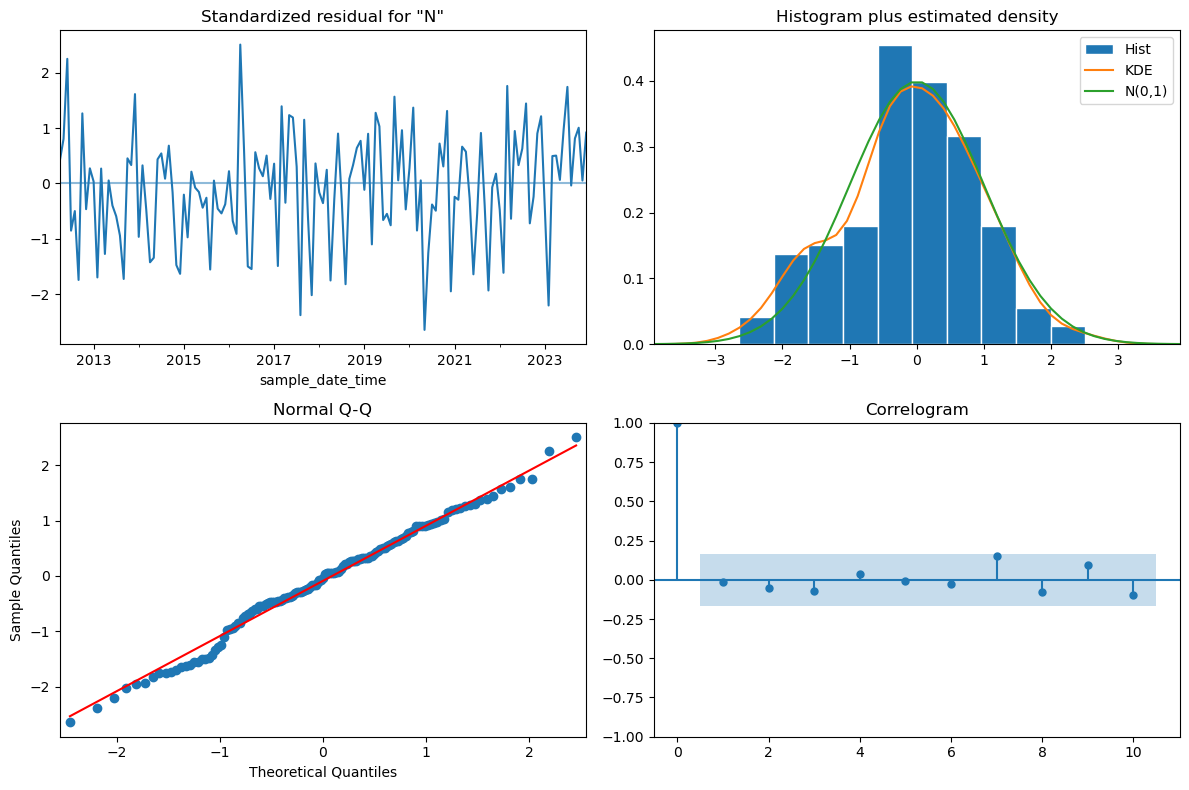

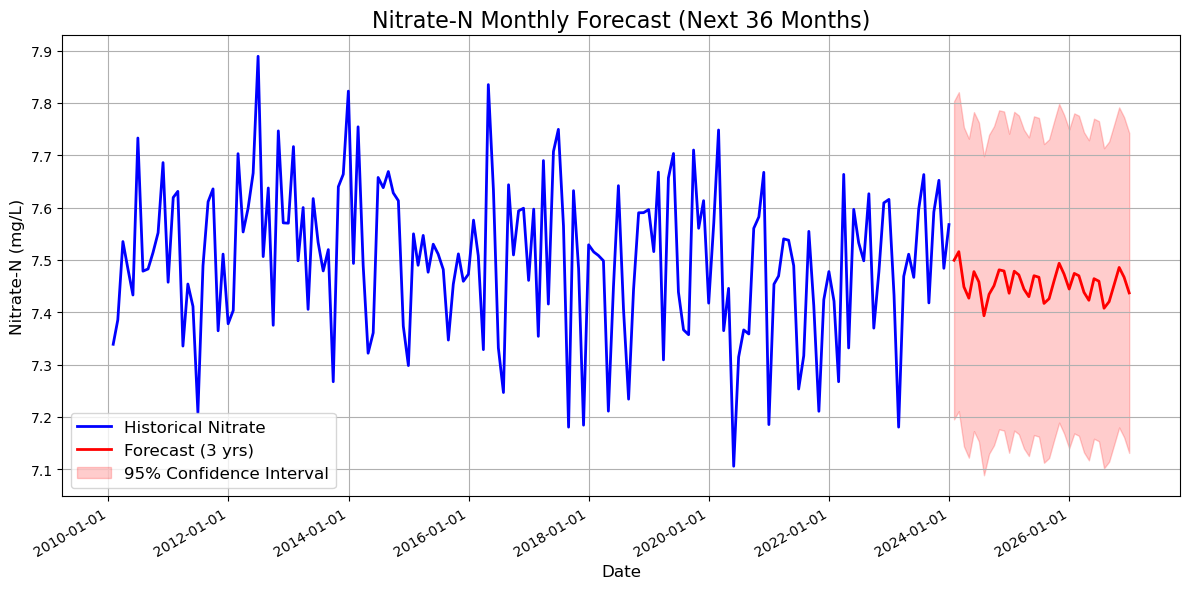


Forecast Summary:
        Forecast   Lower CI   Upper CI
count  36.000000  36.000000  36.000000
mean    7.454814   7.149696   7.759933
std     0.027213   0.027324   0.027113
min     7.393307   7.088406   7.698208
25%     7.435847   7.130623   7.740764
50%     7.458630   7.153223   7.763646
75%     7.473203   7.168282   7.778124
max     7.515808   7.210926   7.820690

Seasonal Analysis:
           mean       min       max
Month                              
1      7.484023  7.474228  7.499372
2      7.485671  7.469795  7.515808
3      7.443596  7.438090  7.448517
4      7.426510  7.422853  7.429742
5      7.470559  7.464156  7.477659
6      7.461387  7.457937  7.466900
7      7.405951  7.393307  7.416878
8      7.426873  7.420311  7.434362
9      7.454273  7.450707  7.459855
10     7.486797  7.481098  7.493634
11     7.472892  7.466956  7.478860
12     7.439238  7.436342  7.444426

Trend Analysis:
Overall trend: Decreasing
Average monthly change: -0.0005 mg/L


In [11]:
# For Nitrate 
def plot_seasonal_decompose(series):
    result = seasonal_decompose(series, model='additive')
    
    fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
    
    axes[0].plot(result.observed, color='c', linewidth=2)
    axes[0].set_title('Observed', fontsize=14)
    axes[0].grid(True)
    
    axes[1].plot(result.trend, color='c', linewidth=2)
    axes[1].set_title('Trend', fontsize=14)
    axes[1].grid(True)
    
    axes[2].plot(result.seasonal, color='c', linewidth=2)
    axes[2].set_title('Seasonal', fontsize=14)
    axes[2].grid(True)
    
    axes[3].plot(result.resid, color='c', linewidth=2)
    axes[3].set_title('Residual', fontsize=14)
    axes[3].grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_diagnostics(results):
    fig = results.plot_diagnostics(figsize=(12, 8))
    plt.tight_layout()
    plt.show()

def forecast_nitrate_3yr(df, date_col="sample_date_time", param_col="Nitrate-N"):
    # Drop missing values in the parameter column
    df = df.dropna(subset=[param_col]).copy()
    
    # Remove outliers using IQR method with 0.1 and 0.9 quantiles
    Q1 = df[param_col].quantile(0.1)
    Q3 = df[param_col].quantile(0.9)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[param_col] >= lower_bound) & (df[param_col] <= upper_bound)].copy()
    
    # Apply threshold: keep only values between 5 and 10 mg/L
    df = df[(df[param_col] >= 5) & (df[param_col] <= 10)].copy()
    
    # Convert date column to datetime, sort, and set as index
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df.sort_values(by=date_col, inplace=True)
    df.set_index(date_col, inplace=True)
    
    # Resample data to monthly means
    df_monthly = df[param_col].resample("M").mean().dropna()
    
    if len(df_monthly) < 12:
        raise ValueError("Not enough data after outlier removal and resampling.")
    
    # Plot seasonal decomposition
    plot_seasonal_decompose(df_monthly)
    
    try:
        # Fit SARIMA model (with seasonal period of 12 months)
        model = sm.tsa.statespace.SARIMAX(
            df_monthly,
            order=(1, 1, 1),
            seasonal_order=(1, 1, 1, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        results = model.fit(disp=False)
        print(results.summary())
        
        # Plot model diagnostics
        plot_diagnostics(results)
    except Exception as e:
        print(f"Error fitting the model: {e}")
        return None, None
    
    # Forecast for 3 years (36 months)
    forecast_steps = 36
    forecast_obj = results.get_forecast(steps=forecast_steps)
    forecast_vals = forecast_obj.predicted_mean
    conf_int = forecast_obj.conf_int()
    
    # Plot historical data and forecast with confidence intervals
    plt.figure(figsize=(12, 6))
    
    plt.plot(df_monthly.index, df_monthly, label="Historical Nitrate", color="blue", linewidth=2)
    
    future_index = forecast_vals.index
    plt.plot(future_index, forecast_vals, label="Forecast (3 yrs)", color="red", linewidth=2)
    
    plt.fill_between(
        future_index,
        conf_int.iloc[:, 0],
        conf_int.iloc[:, 1],
        color="red",
        alpha=0.2,
        label="95% Confidence Interval"
    )
    
    plt.title(f"{param_col} Monthly Forecast (Next 36 Months)", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel(f"{param_col} (mg/L)", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    
    plt.gcf().autofmt_xdate()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    plt.tight_layout()
    plt.show()

    # Forecast Summary 
    if forecast_vals is not None:
        # Create a DataFrame with forecast values and confidence intervals
        forecast_df = pd.DataFrame({
            'Forecast': forecast_vals,
            'Lower CI': conf_int.iloc[:, 0],
            'Upper CI': conf_int.iloc[:, 1]
        })

        print("\nForecast Summary:")
        print(forecast_df.describe())

        print("\nSeasonal Analysis:")
        forecast_df['Month'] = forecast_df.index.month
        seasonal_summary = forecast_df.groupby('Month')['Forecast'].agg(['mean', 'min', 'max'])
        print(seasonal_summary)

        print("\nTrend Analysis:")
        trend = np.polyfit(range(len(forecast_vals)), forecast_vals, 1)
        print(f"Overall trend: {'Increasing' if trend[0] > 0 else 'Decreasing'}")
        print(f"Average monthly change: {trend[0]:.4f} mg/L")
        
        return forecast_vals, conf_int

# Usage
if __name__ == "__main__":
    date_rng = pd.date_range("2010-01-01", "2023-12-01", freq="D")
    np.random.seed(42)
    synthetic_nitrate = 7.5 + np.random.normal(loc=0, scale=0.8, size=len(date_rng))
    
    df_demo = pd.DataFrame({
        "sample_date_time": date_rng,
        "Nitrate-N": synthetic_nitrate
    })
    
    forecast_vals, conf_int = forecast_nitrate_3yr(df_demo, date_col="sample_date_time", param_col="Nitrate-N")

# ARIMA Model for BOD 
## Time Series Decomposition
> The BOD data was decomposed into its components:
- Observed: BOD values generally ranged between 4.3 and 4.7 mg/L over time.
- Trend: A slight declining trend is visible across the timeline, particularly from 2017 onward.
- Seasonal: A clear, repeated annual cycle—indicating strong seasonality in BOD levels.
- Residual: Appears to be randomly scattered, with no significant autocorrelation.

## Model Selection via AIC
> After a stepwise AIC optimization, the best-performing model was selected:
- Best AIC: −160.522 with ARIMA(3,1,0)(4,1,1)[12]
- This model captures both trend and seasonality effectively, using:
- Seasonal lag = 12 (monthly frequency)
- 3 AR terms + seasonal components for complexity and stability.

## Residual Diagnostics
> Residual diagnostic plots indicate:
- Standardized Residuals: Centered around zero with no visible pattern — no autocorrelation.
- Histogram & KDE: Residuals are normally distributed.
- Normal Q-Q Plot: Residuals follow a straight line — confirming normality.
- Correlogram: Residual lags are within confidence bounds — indicating white noise.

All assumptions of a good SARIMA model are met.

## 3-Year Forecast for BOD
> The 36-month forecast for BOD shows the expected trajectory with confidence intervals.

- Forecast Summary:

| Metric   | Forecast | Lower CI | Upper CI |
|----------|---------|----------|----------|
| Mean     | 4.5324  | 4.1231   | 4.9417   |
| Std Dev  | 0.0438  | 0.1087   | 0.1034   |
| Min      | 4.4665  | 3.9463   | 4.7613   |
| Max      | 4.6270  | 4.3337   | 5.1576   |

- The forecast remains steady near 4.5 mg/L.
- Confidence intervals widen over time — indicating increasing forecast uncertainty.

## Seasonal and Trend Analysis
> Seasonal Averages:

| Month | Mean (mg/L) |
|-------|------------|
| Jan   | 4.5540     |
| Feb   | 4.5635     |
| Mar   | 4.5325     |
| Apr   | 4.5358     |
| May   | 4.5045     |
| Jun   | 4.4887     |
| Jul   | 4.4856     |
| Aug   | 4.5083     |
| Sep   | 4.5673     |
| Oct   | 4.5418     |
| Nov   | 4.6153     |
| Dec   | 4.4913     |

- Seasonal variation is noticeable, with higher BOD levels in Feb–Mar and Sep–Nov, and lower in Jun–Jul.

> Trend:
- Overall trend: Slightly Decreasing
- Avg monthly change: −0.0003 mg/L

## Key Insights
- Model Fit: ARIMA(3,1,0)(4,1,1)[12] provides a robust and well-validated fit for BOD time series.
- Seasonality: Strong annual seasonality persists across all years.
- Forecast Stability: Forecast remains stable near historical average with modest variance.
- Residuals: Behave like white noise — confirms no major pattern left unexplained.
- Environmental Implication: A slight downward trend suggests ongoing improvement or natural variation in BOD levels. Continued monitoring recommended.

/var/folders/6f/hrr6km6x5l39n_12_r7994t00000gn/T/ipykernel_64685/1141304226.py:65: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df[param_col].resample("M").mean().dropna()


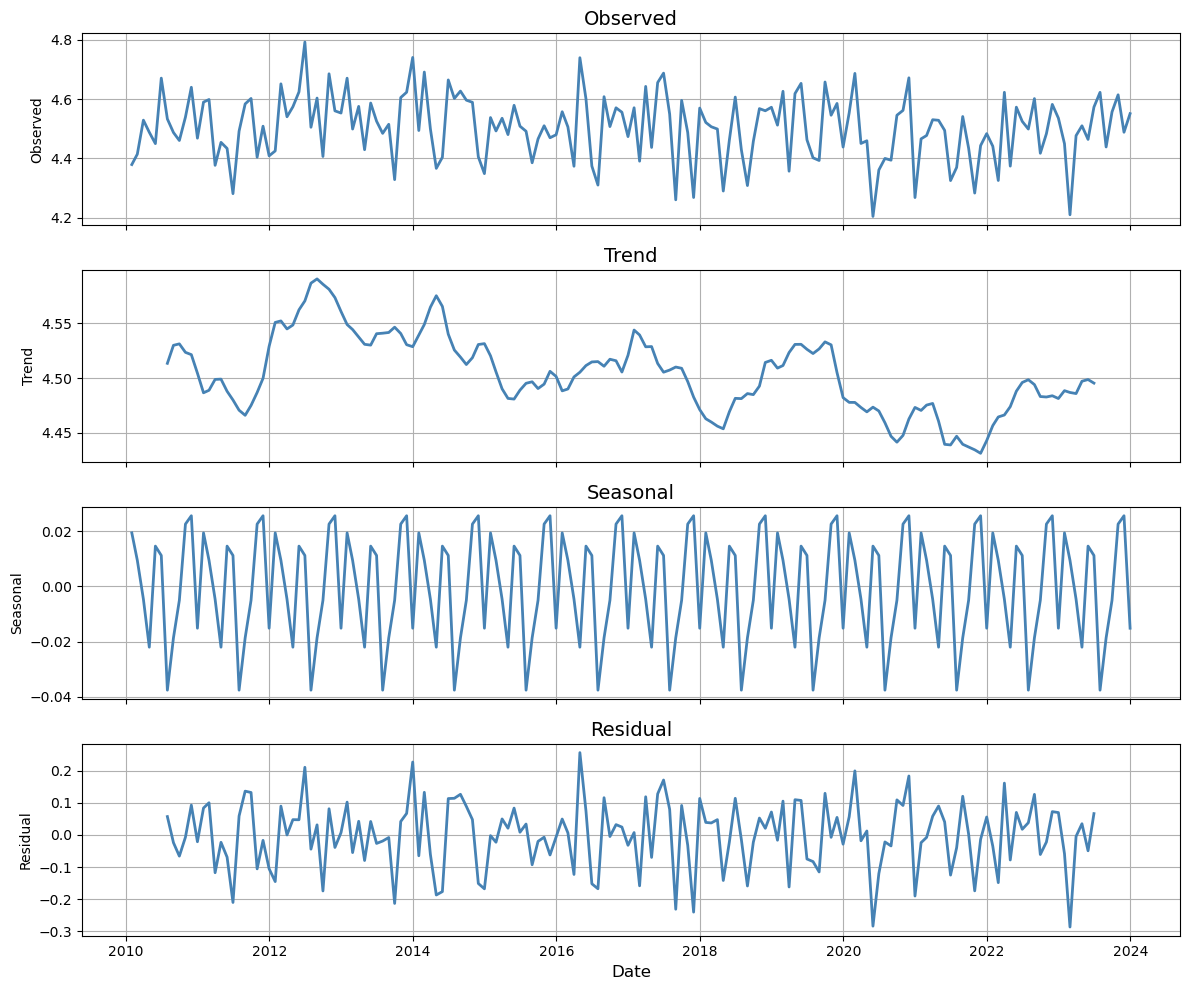

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-29.555, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-98.292, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.41 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-62.404, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-112.184, Time=0.30 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=-120.125, Time=0.81 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=-133.290, Time=2.16 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=-133.250, Time=4.98 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=5.60 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.60 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=10.06 sec
 ARIMA(0,1,0)(4,1,0)[12]             : AIC=-101.801, Time=0.90 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=-147.893, Time=2.18 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=-119.920, Time=0.48 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AI

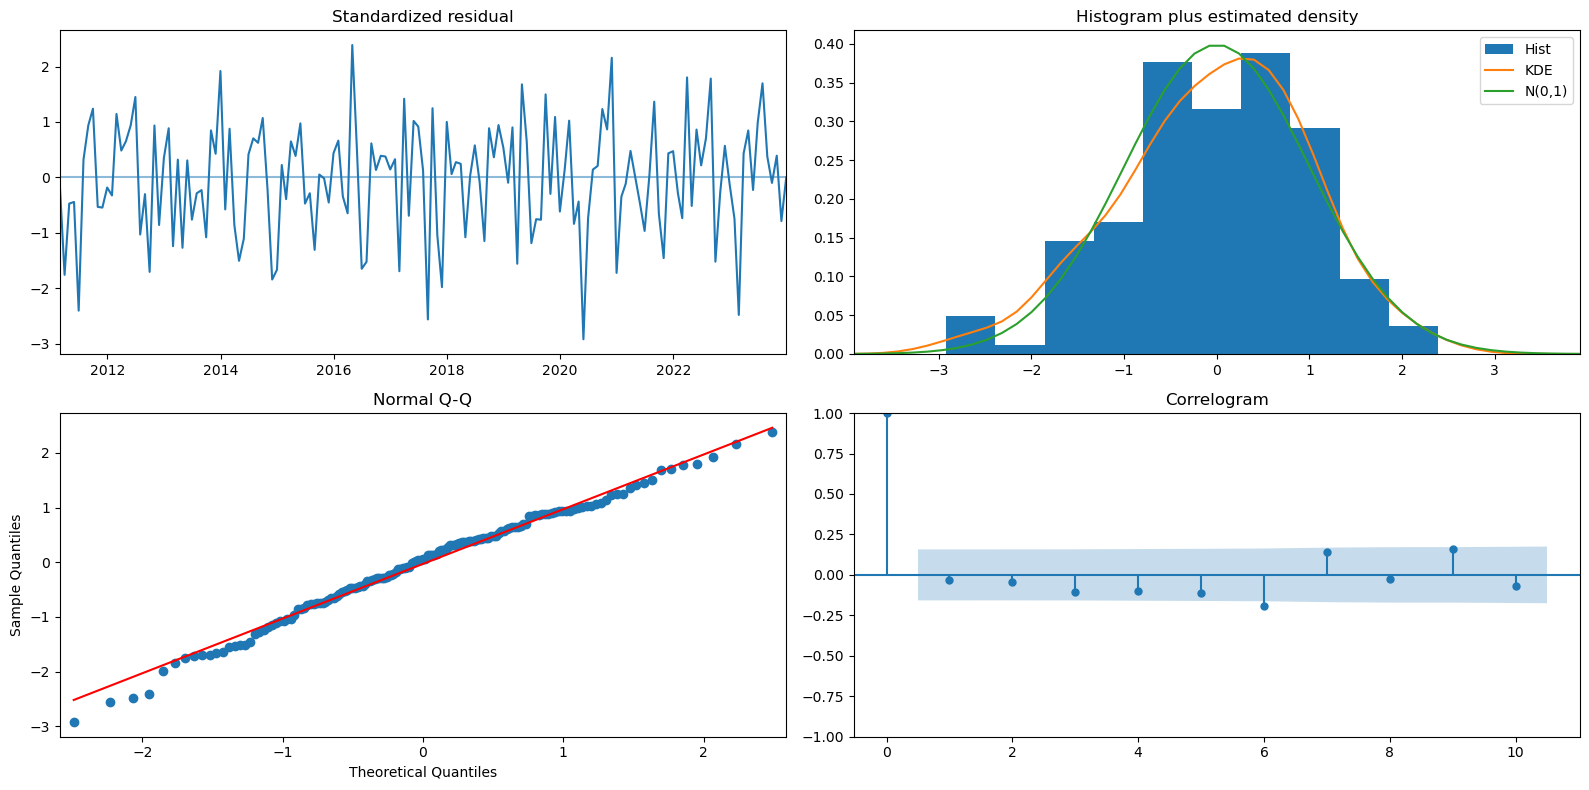

/var/folders/6f/hrr6km6x5l39n_12_r7994t00000gn/T/ipykernel_64685/1141304226.py:92: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_index = pd.date_range(start=df_monthly.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='M')


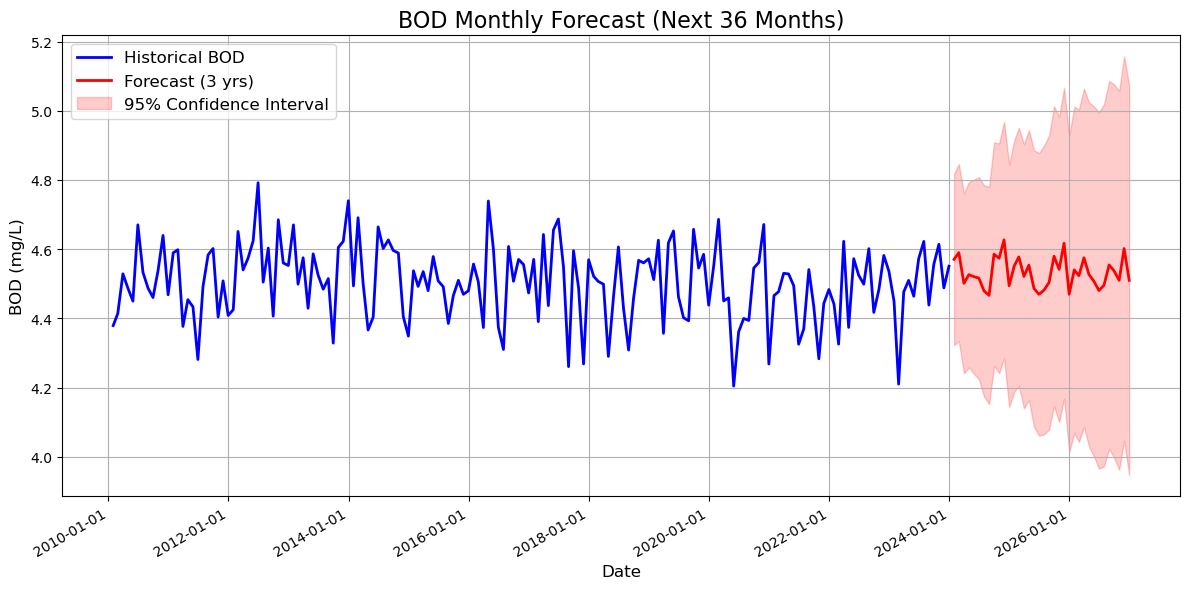


Forecast Summary:
        Forecast   Lower CI   Upper CI
count  36.000000  36.000000  36.000000
mean    4.532386   4.123106   4.941666
std     0.043801   0.108680   0.103424
min     4.466510   3.946300   4.761336
25%     4.499822   4.039597   4.869849
50%     4.524687   4.119856   4.936958
75%     4.571362   4.209662   5.014670
max     4.626972   4.333650   5.157571

Seasonal Statistics:
           mean       min       max
Month                              
1      4.554020  4.540042  4.570550
2      4.563519  4.523153  4.589776
3      4.532469  4.501095  4.575021
4      4.535785  4.526221  4.553865
5      4.504471  4.486328  4.520406
6      4.488679  4.469444  4.516304
7      4.485626  4.479419  4.496002
8      4.508339  4.466510  4.554430
9      4.567331  4.537100  4.585357
10     4.541797  4.509928  4.573799
11     4.615288  4.601733  4.626972
12     4.491307  4.469653  4.509985

Trend Analysis:
Overall trend: Decreasing
Average monthly change: -0.0003 mg/L
Forecasting completed su

In [12]:
# For BOD
def plot_seasonal_decompose(series):
    try:
        result = seasonal_decompose(series, model='additive')
        
        fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
        
        axes[0].plot(result.observed, color='steelblue', linewidth=2)
        axes[0].set_title('Observed', fontsize=14)
        axes[0].set_ylabel('Observed')
        axes[0].grid(True)
        
        axes[1].plot(result.trend, color='steelblue', linewidth=2)
        axes[1].set_title('Trend', fontsize=14)
        axes[1].set_ylabel('Trend')
        axes[1].grid(True)
        
        axes[2].plot(result.seasonal, color='steelblue', linewidth=2)
        axes[2].set_title('Seasonal', fontsize=14)
        axes[2].set_ylabel('Seasonal')
        axes[2].grid(True)
        
        axes[3].plot(result.resid, color='steelblue', linewidth=2)
        axes[3].set_title('Residual', fontsize=14)
        axes[3].set_ylabel('Residual')
        axes[3].grid(True)
        
        plt.xlabel("Date", fontsize=12)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error in seasonal decomposition: {e}")

def plot_diagnostics(results):
    try:
        fig = results.plot_diagnostics(figsize=(16, 8))
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error in plotting diagnostics: {e}")

def forecast_bod_3yr(df, date_col="sample_date_time", param_col="BOD"):
    try:
        # Drop missing values in the parameter column
        df = df.dropna(subset=[param_col]).copy()
        
        # Remove outliers using IQR method with 0.1 and 0.9 quantiles
        Q1 = df[param_col].quantile(0.1)
        Q3 = df[param_col].quantile(0.9)
        IQR = Q3 - Q1
        lower_bound = max(Q1 - 1.5 * IQR, 0)  # Ensure non-negative values
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[param_col] >= lower_bound) & (df[param_col] <= upper_bound)].copy()
        
        # Convert date column to datetime, sort by date, and set as index
        df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
        df.sort_values(by=date_col, inplace=True)
        
        if df.empty:
            raise ValueError("No valid data after outlier removal.")
        
        df.set_index(date_col, inplace=True)
        
        # Resample data to monthly means
        df_monthly = df[param_col].resample("M").mean().dropna()
        
        if len(df_monthly) < 12:
            raise ValueError("Insufficient data (<12 months) after filtering and resampling.")
        
        # Plot seasonal decomposition
        plot_seasonal_decompose(df_monthly)
        
        # Fit auto ARIMA model
        auto_model = auto_arima(df_monthly, seasonal=True, m=12,
                                start_p=0, start_q=0, max_p=5, max_q=5,
                                start_P=0, start_Q=0, max_P=5, max_Q=5,
                                d=1, D=1,  # Set d and D to 1 to ensure differencing
                                trace=True, error_action='ignore',
                                suppress_warnings=True, stepwise=True)
        
        results = auto_model.fit(df_monthly)
        print(results.summary())
        
        # Plot model diagnostics
        plot_diagnostics(results)
        
        # Forecast for 3 years (36 months)
        forecast_steps = 36
        forecast_vals, conf_int = results.predict(n_periods=forecast_steps, return_conf_int=True)
        
        # Create future index for plotting
        future_index = pd.date_range(start=df_monthly.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='M')
        
        # Plot historical data and forecast with confidence intervals
        plt.figure(figsize=(12, 6))
        
        plt.plot(df_monthly.index, df_monthly, label="Historical BOD", color="blue", linewidth=2)
        plt.plot(future_index, forecast_vals, label="Forecast (3 yrs)", color="red", linewidth=2)
        
        plt.fill_between(
            future_index,
            conf_int[:, 0],
            conf_int[:, 1],
            color="red",
            alpha=0.2,
            label="95% Confidence Interval"
        )
        
        plt.title(f"{param_col} Monthly Forecast (Next 36 Months)", fontsize=16)
        plt.xlabel("Date", fontsize=12)
        plt.ylabel(f"{param_col} (mg/L)", fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(True)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gcf().autofmt_xdate()
        plt.tight_layout()
        plt.show()
        
        # Forecast Summary 
        print("\nForecast Summary:")
        summary_df = pd.DataFrame({
            'Forecast': forecast_vals,
            'Lower CI': conf_int[:, 0],
            'Upper CI': conf_int[:, 1]
        }, index=future_index)

        print(summary_df.describe())
        
        print("\nSeasonal Statistics:")
        summary_df['Month'] = summary_df.index.month
        seasonal_summary = summary_df.groupby('Month')['Forecast'].agg(['mean', 'min', 'max'])
        print(seasonal_summary)

        print("\nTrend Analysis:")
        trend = np.polyfit(range(len(forecast_vals)), forecast_vals, 1)  # Linear trend analysis
        print(f"Overall trend: {'Increasing' if trend[0] > 0 else 'Decreasing'}")
        print(f"Average monthly change: {trend[0]:.4f} mg/L")
        
        return forecast_vals, conf_int
    
    except Exception as e:
        print(f"Error in forecast_bod_3yr: {e}")
        return None, None

# Usage Example
if __name__ == "__main__":
    try:
        date_rng = pd.date_range("2010-01-01", "2023-12-01", freq="D")
        
        np.random.seed(42)
        synthetic_bod = 4.5 + np.random.normal(loc=0, scale=0.6, size=len(date_rng))
        
        df_demo = pd.DataFrame({
            "sample_date_time": date_rng,
            "BOD": np.clip(synthetic_bod, 3.0, 6.0)  # Clip values to a realistic range
        })
        
        forecast_vals, conf_int = forecast_bod_3yr(df_demo, date_col="sample_date_time", param_col="BOD")
        
        if forecast_vals is not None and conf_int is not None:
            print("Forecasting completed successfully.")
        else:
            print("Forecasting failed.")
    
    except Exception as e:
        print(f"Error in main execution: {e}")
